In [51]:
import numpy as np
import os
import json
from zipfile import ZipFile

In [52]:
# Loading Kaggle credentials and downloading the dataset

kaggle_credentials = json.load(open("kaggle.json"))

os.environ["KAGGLE_USERNAME"] = kaggle_credentials['username']
os.environ["KAGGLE_KEY"] = kaggle_credentials["key"]

!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset


#Unzip 
with ZipFile("corn-or-maize-leaf-disease-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("corn_disease_dataset")

^C
Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
corn-or-maize-leaf-disease-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


## Counting number of images in each folder

In [55]:
def count_images_in_folders(folder_path):
    import os

    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    total_images = 0
    print(f"\nChecking folder: {folder_path}")
    
    for cls in sorted(os.listdir(folder_path)):
        cls_path = os.path.join(folder_path, cls)
        if os.path.isdir(cls_path):
            count = len([file for file in os.listdir(cls_path) if file.lower().endswith(image_extensions)])
            total_images += count
            print(f"{cls}: {count} images")
    
    print(f"\nTotal images: {total_images}")

count_images_in_folders("C:\ML Implementation\Corn-disease\corn_disease_dataset\data")


Checking folder: C:\ML Implementation\Corn-disease\corn_disease_dataset\data
Blight: 1146 images
Common_Rust: 1306 images
Gray_Leaf_Spot: 1200 images
Healthy: 1162 images

Total images: 4814


## Checking for Corrupt and Unreadable Images

In [56]:
from PIL import Image

def check_image_integrity(folder_path):
    broken = []
    total_checked = 0
    corrupt_count = 0

    print(f"\nChecking image integrity in: {folder_path}")
    for cls in sorted(os.listdir(folder_path)):
        cls_path = os.path.join(folder_path, cls)
        if not os.path.isdir(cls_path):
            continue
              
        for img_file in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_file)
            try:
                img_path = os.path.join(cls_path, img_file)
                with Image.open(img_path) as img:
                    img.verify()
                    total_checked += 1
                    
            except Exception as e:
                broken.append(img_path)
                corrupt_count += 1
                print(f"Corrupt: {img_path} — {e}")
                

    print(f"\nTotal images checked: {total_checked + corrupt_count}")
    print(f"Valid images: {total_checked}")
    print(f"Corrupt images: {corrupt_count}")


    if not broken:
        print("All images verified successfully.")
    else:
        print(f"Found {len(broken)} corrupt images.")

# Run this:
check_image_integrity("C:/ML Implementation/Corn-disease/corn_disease_dataset/data")



Checking image integrity in: C:/ML Implementation/Corn-disease/corn_disease_dataset/data

Total images checked: 4814
Valid images: 4814
Corrupt images: 0
All images verified successfully.


In [57]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy

# Declaring Variables

In [58]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

# Loading the full dataset

In [59]:
dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/ML Implementation/Corn-disease/corn_disease_dataset/data",
     shuffle = True,
     image_size = (IMAGE_SIZE, IMAGE_SIZE),
     batch_size = BATCH_SIZE
)

Found 4814 files belonging to 4 classes.


In [60]:
class_names  = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [61]:
len(dataset) 

151

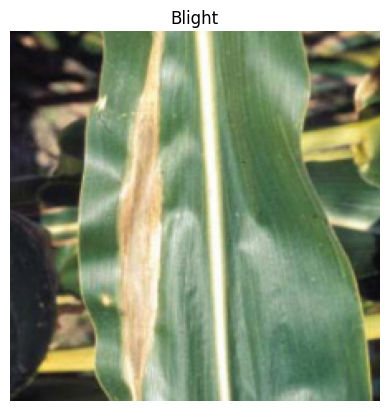

In [62]:
# Take one batch (usually of 32 images) from the dataset
for image_batch, label_batch in dataset.take(1):
    
    # Convert the first image in the batch to a NumPy array and display it
    plt.imshow(image_batch[0].numpy().astype("uint8")) # .astype("uint8") ensures correct color format
   
    # Convert the label tensor to a NumPy integer, use it to get the class name, and set as title
    plt.title( class_names[label_batch[0]]) 
    
    plt.axis("off") # Turn off the axis ticks and grid for cleaner display
    

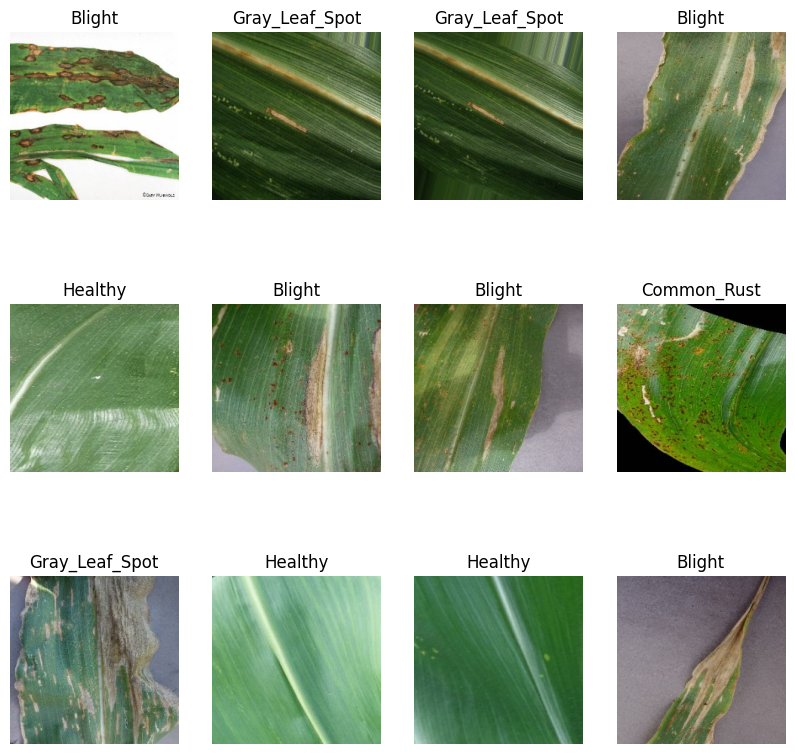

In [63]:
plt.figure(figsize = (10,10)) # Set the figure size (10x10 inches)

# Take one batch (usually of 32 images) from the dataset
for image_batch, label_batch in dataset.take(1):

    # Loop through the first 12 images in the batch
    for i in range(12):

        # Create a subplot in a 3x4 grid (3 rows, 4 columns)
        ax = plt.subplot(3,4, i+1)
    
        # Convert the 12 images in the batch to a NumPy array and display it
        plt.imshow(image_batch[i].numpy().astype("uint8")) # .astype("uint8") ensures correct color format
   
        # Convert the label tensor to a NumPy integer, use it to get the class name, and set as title
        plt.title( class_names[label_batch[i]]) 
    
        plt.axis("off") # Turn off the axis ticks and grid for cleaner display

# Splitting the dataset

In [64]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 123)

    
    train_size = int(train_split * ds_size) 
    val_size = int(val_split * ds_size) 

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [65]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [66]:
len(train_ds)

120

In [67]:
len(val_ds)

15

In [68]:
len(test_ds)

16

In [69]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessing the Data

## Resizing & Rescaling

In [70]:

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

## Data Augmentation

In [71]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# CNN Model Implementation

In [72]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

n_classes = 4

model = models.Sequential([
    tf.keras.Input(shape = (input_shape), batch_size = BATCH_SIZE),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

In [73]:
model.summary() #Gives summary of the model

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 sequential_8 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 111, 111, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 54, 54, 64)          0         
 ng2D)                                                

# Model Compilation

In [74]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [75]:
history = model.fit(
    train_ds,
    epochs= EPOCHS,
    validation_data=val_ds,
)

Epoch 1/30
120/120 [==============================] - 107s 830ms/step - loss: 0.7025 - accuracy: 0.6991 - val_loss: 0.4514 - val_accuracy: 0.7563
Epoch 2/30
120/120 [==============================] - 85s 706ms/step - loss: 0.4167 - accuracy: 0.8344 - val_loss: 0.3306 - val_accuracy: 0.8646
Epoch 3/30
120/120 [==============================] - 85s 705ms/step - loss: 0.3572 - accuracy: 0.8600 - val_loss: 0.2961 - val_accuracy: 0.8833
Epoch 4/30
120/120 [==============================] - 86s 716ms/step - loss: 0.3379 - accuracy: 0.8736 - val_loss: 0.2835 - val_accuracy: 0.8813
Epoch 5/30
120/120 [==============================] - 87s 725ms/step - loss: 0.3252 - accuracy: 0.8765 - val_loss: 0.5306 - val_accuracy: 0.7688
Epoch 6/30
120/120 [==============================] - 86s 717ms/step - loss: 0.3025 - accuracy: 0.8794 - val_loss: 0.2785 - val_accuracy: 0.8708
Epoch 7/30
120/120 [==============================] - 85s 711ms/step - loss: 0.2887 - accuracy: 0.8841 - val_loss: 0.2938 - val_a

In [76]:
acc= history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

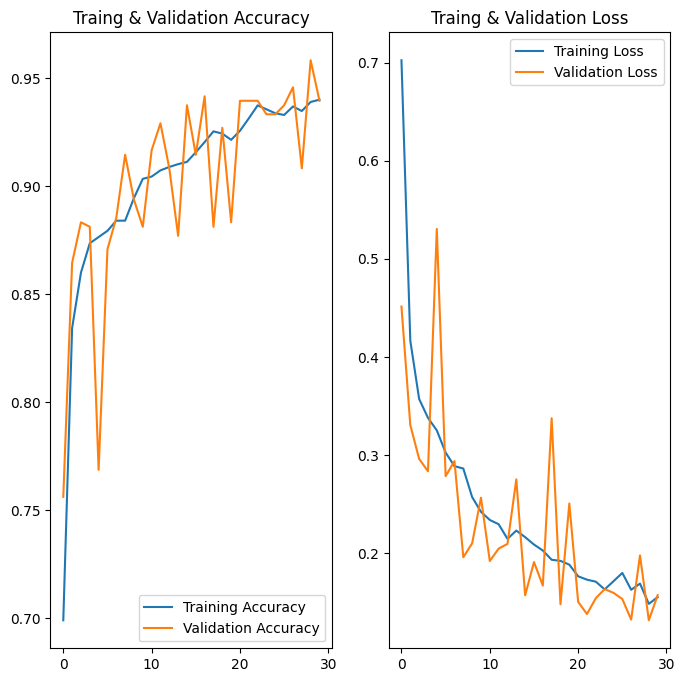

In [77]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Traing & Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(len(loss)), loss, label = 'Training Loss')
plt.plot(range(len(val_loss)), val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Traing & Validation Loss')
plt.show()

First image to predict
First image's actual label :  Common_Rust
1/1 [==============================] - 0s 329ms/step
Predicted label:  Common_Rust


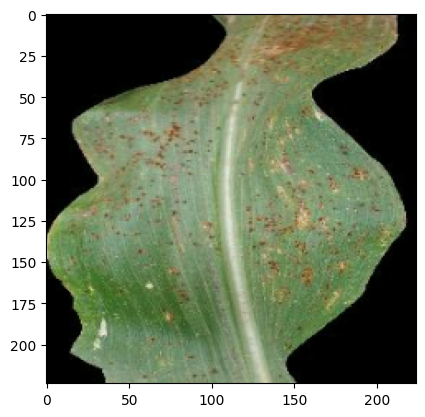

In [78]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("First image's actual label : ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label: ",class_names[np.argmax(batch_prediction[0])])


In [79]:
def predict(model, img):
    
    img_array = tf.expand_dims(img, 0) # create batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])))
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


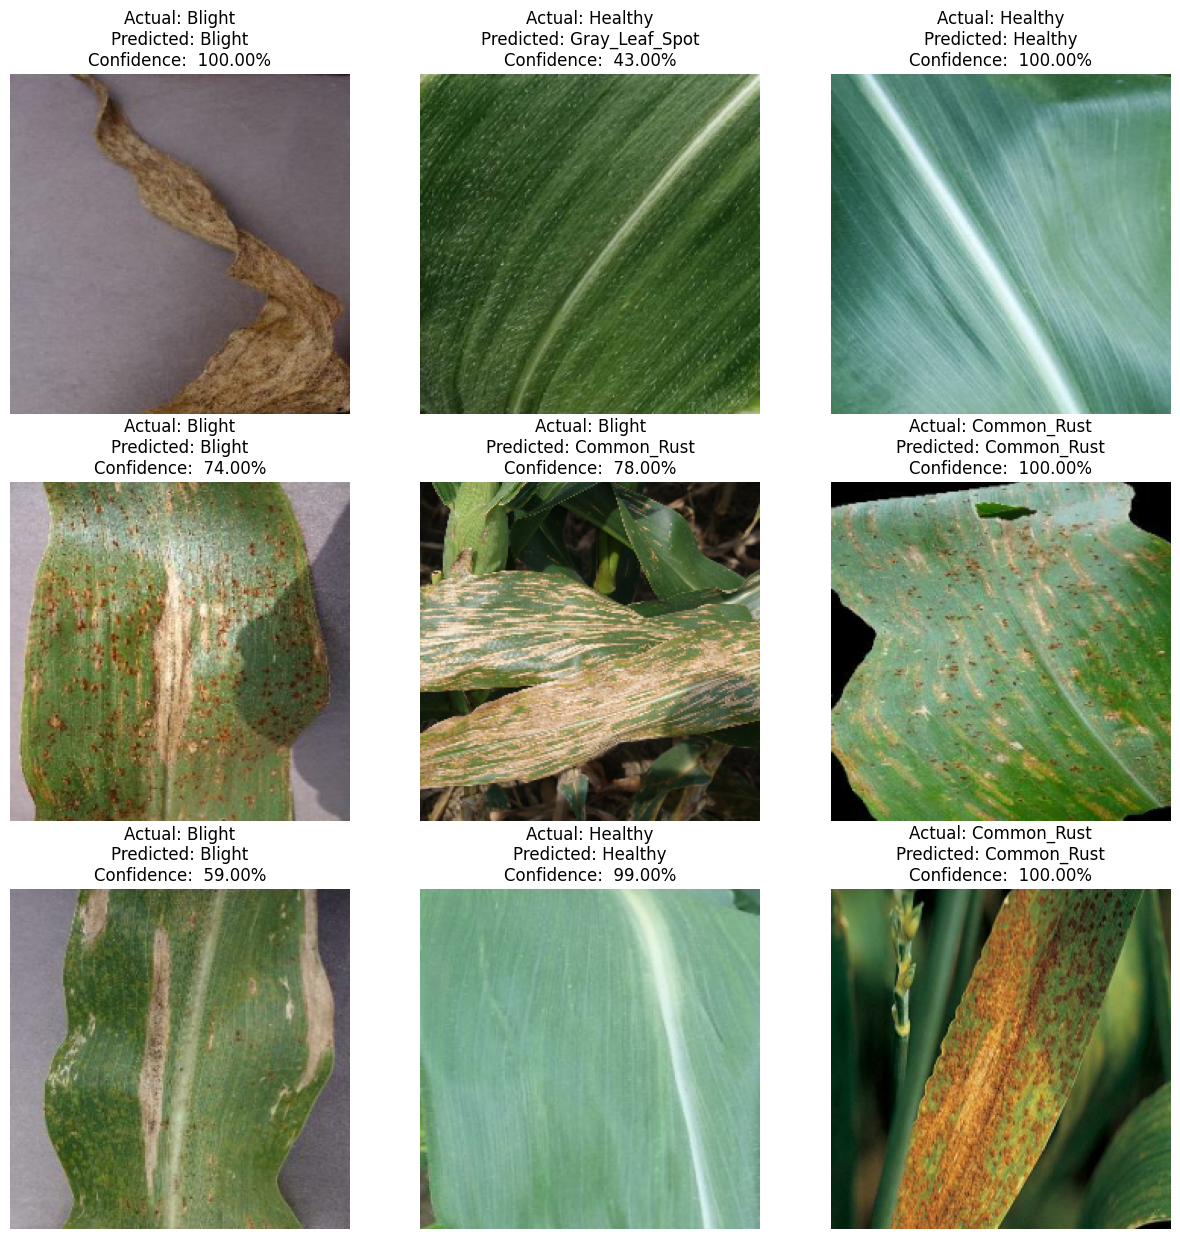

In [80]:
plt.figure(figsize= (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence: .2f}%")

        
        plt.axis('off')

# Model Predictions

In [81]:
import numpy as np

y_true = []
y_pred = []
y_prob = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)  # shape (batch_size,)
    true_classes = labels.numpy()             # shape (batch_size,)
    

    y_true.extend(true_classes)
    y_pred.extend(preds_classes)
    y_prob.extend(preds)
    
# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)  

1/1 [==============================] - 0s 159ms/step


In [82]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Accuracy

In [83]:
acc = accuracy_score(y_true, y_pred)

In [84]:
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 93.96%


# Precision

In [85]:
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro', 'micro'

In [86]:
print(f"Precision: {precision * 100:.2f}%")

Precision: 94.00%


# Recall

In [87]:
recall = recall_score(y_true, y_pred, average='weighted')

In [88]:
print(f"Recall: {recall * 100:.2f}%")

Recall: 93.96%


# F1 Score

In [89]:
f1 = f1_score(y_true, y_pred, average='weighted')

In [90]:
print(f"f1: {f1 * 100:.2f}%")

f1: 93.94%


# Confusion Matrix

In [91]:
cm = confusion_matrix(y_true, y_pred)

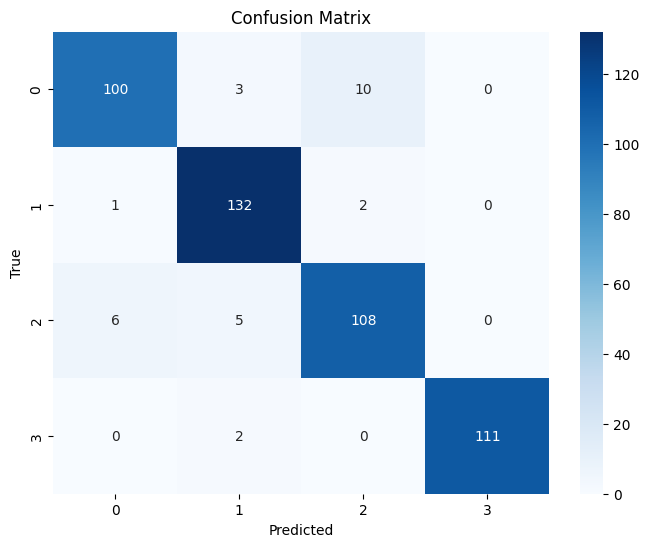

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# AUROC

In [93]:
from sklearn.metrics import roc_auc_score

try:
    auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro') * 100
    print(f"Macro-Averaged ROC-AUC Score: {auc_score:.2f}%")
except Exception as e:
    print("ROC AUC not available:", e)


Macro-Averaged ROC-AUC Score: 99.48%


In [94]:
import os
print("Current working directory:", os.getcwd())

Current working directory: C:\ML Implementation\Corn-disease


In [95]:
model_version= "CNN_image_size_224"
model.save(f"./models/{model_version}.keras")